# **Подготовка обучающей и тестовой выборки, кросс-валидация и подбор гиперпараметров на примере метода ближайших соседей.**


**Цель лабораторной работы**: изучение способов подготовки выборки и подбора гиперпараметров на примере метода ближайших соседей.

**Задание:**
- Выберите набор данных (датасет) для решения задачи классификации или регрессии.
- С использованием метода train_test_split разделите выборку на обучающую и тестовую.
- Обучите модель ближайших соседей для произвольно заданного гиперпараметра K. - Оцените качество модели с помощью подходящих для задачи метрик.
- Произведите подбор гиперпараметра K с использованием GridSearchCV и/или RandomizedSearchCV и кросс-валидации, оцените качество оптимальной модели. Желательно использование нескольких стратегий кросс-валидации.
Сравните метрики качества исходной и оптимальной моделей.

### **Импорт библиотек и загрузка датасета**
Импортируем библиотеки с помощью команды import.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")
from sklearn.model_selection import train_test_split
from operator import itemgetter
import matplotlib.ticker as ticker
import math
from enum import Enum
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from typing import Dict, Tuple
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, fbeta_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut, ShuffleSplit, StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import learning_curve, validation_curve

In [2]:
filename = 'water_potability.csv'
data = pd.read_csv(filename)

In [3]:
data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


### **Очистка датасета**

Основываясь на том, что мы делали выше, обработаем все остальные столбцы и таким образом полностью почистим набор

In [4]:
data.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [5]:
data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [6]:
# проверим пропущенные значения
data.isnull().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [7]:
strategies=['mean', 'median', 'most_frequent']

In [8]:
# импьютация нужной колонки с помощью нужной стратегии
def func_impute_col(dataset, column, strategy_param):
    temp_data = dataset[[column]]
    
    imp_num = SimpleImputer(strategy=strategy_param)
    data_num_imp = imp_num.fit_transform(temp_data)
    
    return data_num_imp

In [9]:
# замена медианой pH
col_imp = func_impute_col(data, 'ph', strategies[1])
data[['ph']] = col_imp

In [10]:
# замена медианой Sulfate
col_imp = func_impute_col(data, 'Sulfate', strategies[1])
data[['Sulfate']] = col_imp

In [11]:
# замена медианой Sulfate
col_imp = func_impute_col(data, 'Trihalomethanes', strategies[1])
data[['Trihalomethanes']] = col_imp

In [12]:
# проверим пропущенные значения
data.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

### **Разделение выборки на обучающую и тестовую**

In [13]:
# целевой признак - Potability - указывает, безопасна ли вода для потребления человеком 
target = data['Potability']

In [14]:
data.corr()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
ph,1.000000,0.075760,-0.082004,-0.031741,0.014178,0.017466,0.040240,0.003145,-0.036107,-0.003014
Hardness,0.075760,1.000000,-0.046899,-0.030054,-0.092833,-0.023915,0.003610,-0.012707,-0.014449,-0.013837
Solids,-0.082004,-0.046899,1.000000,-0.070148,-0.149747,0.013831,0.010242,-0.008799,0.019546,0.033743
Chloramines,-0.031741,-0.030054,-0.070148,1.000000,0.023762,-0.020486,-0.012653,0.016614,0.002363,0.023779
Sulfate,0.014178,-0.092833,-0.149747,0.023762,1.000000,-0.014182,0.027102,-0.025657,-0.009767,-0.020476
Conductivity,0.017466,-0.023915,0.013831,-0.020486,-0.014182,1.000000,0.020966,0.001184,0.005798,-0.008128
Organic_carbon,0.040240,0.003610,0.010242,-0.012653,0.027102,0.020966,1.000000,-0.012958,-0.027308,-0.030001
Trihalomethanes,0.003145,-0.012707,-0.008799,0.016614,-0.025657,0.001184,-0.012958,1.000000,-0.021487,0.006887
Turbidity,-0.036107,-0.014449,0.019546,0.002363,-0.009767,0.005798,-0.027308,-0.021487,1.000000,0.001581
Potability,-0.003014,-0.013837,0.033743,0.023779,-0.020476,-0.008128,-0.030001,0.006887,0.001581,1.000000


In [15]:
# уберем столбцы, слабо коррелирующие с целевым признаком
data_clean = data
data_clean = data_clean.drop(columns = ['ph'], axis = 1)
data_clean = data_clean.drop(columns = ['Conductivity'], axis = 1)
data_clean = data_clean.drop(columns = ['Trihalomethanes'], axis = 1)
data_clean = data_clean.drop(columns = ['Turbidity'], axis = 1)
data_clean = data_clean.drop(columns = ['Hardness'], axis = 1)

In [16]:
x_train,x_test,y_train,y_test=train_test_split(data,target,test_size=0.2,random_state=1)

## **Обучение модели ближайших соседей для произвольно заданного гиперпараметра K**

Параметр y предназначен для регрессии. Построим на основе его признак для классификации.

In [17]:
def regr_to_class(y: int) -> str:
    if y==1:
        return 'Is_safe'
    else:
        return 'Not_safe'

In [18]:
# формирование целевого признака для классификации
x_train['Potability_class'] = \
x_train.apply(lambda row: regr_to_class(row['Potability']),axis=1)

Мы будем решать задачу классификации, т.к. в модели всего 2 возможных значения для целевого признака: вода или безопасна для питья или нет.

### **Метод k-ближайших соседей**

In [19]:
class PredictionType(Enum):
    CLASSIFICATION = 1
    REGRESSION = 2

In [20]:
class SimpleKNN:
    
    def fit(self, X_train: np.matrix, y_train: np.ndarray):
        """
        Метод обучения, который фактически не учится, 
        а только запоминает обучающую выборку.
        Входные параметры:
        X_train - обучающая выборка (матрица объект-признак)
        y_train - обучающая выборка (вектор целевого признака)
        Возвращаемое значение: нет
        """
        #Сохраняем параметры в переменных класса
        self._X_train = X_train
        self._y_train = y_train
          
    def eucl_dist(self, p: np.ndarray, q: np.ndarray) -> float:
        """
        Вычисление Евклидова расстояния - https://en.wikipedia.org/wiki/Euclidean_distance 
        Входные параметры:
        p, q - вектора в n-мерном пространстве признаков
        """
        return math.sqrt(sum([(pi - qi) ** 2 for pi, qi in zip (p, q)]))
            
            
    def predict_for_single_object(self, K: int, \
                prediction_type: PredictionType, \
                X_o: np.ndarray, \
                verbose = True) -> np.ndarray:
        """
        Метод предсказания для одного объекта.
        Входные параметры:
        K - гиперпараметр, количество соседей 
        prediction_type - классификация или регрессия 
        X_o - строка матрицы объект-признак, соответствующая объекту
        verbose - флаг детального вывода
        Возвращаемое значение: предсказанное значение целевого признака
        """
        # список соседей
        neighbors_list = []
        # *** Находим ближайшие точки ***
        # Перебираем все точки обучающей выборки
        for i in range(self._X_train.shape[0]):
            # получаем текущую точку
            data_train_current_x = [x for x in self._X_train[['Solids','Chloramines', 'Sulfate', 'Organic_carbon']].iloc[i]]
            # и значение ее y
            data_train_current_y = self._y_train.values[i]
            # вычисляем расстояние
            dist = self.eucl_dist(X_o, data_train_current_x)
            # сохраняем в список соседей
            temp_res = (data_train_current_y, dist, data_train_current_x)
            neighbors_list.append(temp_res)
        # *** сортируем список соседей по возрастанию расстояния *** 
        # в кортеже элементы следуют в порядке (0,1,2), сортируем по первому элементу 
        neighbors_list_sorted = sorted(neighbors_list, key=itemgetter(1))
        if verbose:
            print()
            print('**************************************')
            print('Проверяемая точка: ', X_o)
            print('**************************************')
            print('Вывод отсортированного списка соседей:')    
            dist_list = []
            for cur_y, cur_dist, temp_x_1_2 in neighbors_list_sorted:
                temp_x1, temp_x2 = temp_x_1_2
                print('X1={0}, X2={1}, y={2}, расстояние={3:.2f}'.format(temp_x1, temp_x2, cur_y, cur_dist))
                dist_list.append(cur_dist)
            print()
            print('Вывод расстояния для отсортированного списка соседей:')    
            plt.plot(dist_list)
            plt.show()
        # Оставим только K ближайших соседей
        K_neighbors_list_sorted = neighbors_list_sorted[:K]
        if verbose:
            print('Вывод К ближайших соседей:')
            x1_list = []
            x2_list = []
            for cur_y, cur_dist, temp_x_1_2 in K_neighbors_list_sorted:
                temp_x1, temp_x2 = temp_x_1_2
                x1_list.append(temp_x1)
                x2_list.append(temp_x2)
                print('X1={0}, X2={1}, y={2}, расстояние={3:.2f}'.format(temp_x1, temp_x2, cur_y, cur_dist))
            print()
            print('Визуализация К ближайших соседей:')
            plt.plot(self._X_train['x1'], self._X_train['x2'], 'b.', \
                     x1_list, x2_list,  'g*', \
                    [X_o[0]], [X_o[1]], 'ro')
            plt.show()   
        # Результат - классификация или регрессия
        if prediction_type == PredictionType.REGRESSION:
            # используем numpy для вычисления среднего значения
            arr = np.array([x for x,_,_ in K_neighbors_list_sorted])
            # возвращаем среднее значение
            return np.mean(arr)          
        elif prediction_type == PredictionType.CLASSIFICATION:
            k_y_list = [y for y,_,_ in K_neighbors_list_sorted]
            # группируем с количеством метки классов,
            # соответствующие K ближайшим соседям
            k_y_list_grouped_temp = np.unique(k_y_list, return_counts=True)
            k_y_list_grouped = [[key, cnt] for key, cnt in zip(k_y_list_grouped_temp[0], k_y_list_grouped_temp[1])]
            # сортируем по количеству по убыванию
            k_y_list_grouped_sorted = sorted(k_y_list_grouped, key=itemgetter(1), reverse=True)
            if verbose:
                print('Классы, соответствующие К ближайшим соседям:')
                for i in k_y_list_grouped_sorted:
                    print('класс={0}, количество элементов={1}'.format(i[0], i[1]))
            # возвращаеv метку класса из первой строки отсортированного массива
            # то есть того класса, к которому принадлежит наибольшее количество соседей
            return k_y_list_grouped_sorted[0][0]
        else:
            raise Exception('Неизвестный тип предсказания')
                   
    
    def predict(self, K: int, \
                prediction_type: PredictionType, \
                X_test: np.matrix, 
                verbose = True) -> np.ndarray:
        """
        Метод предсказания.
        Входные параметры:
        K - гиперпараметр, количество соседей 
        prediction_type - классификация или регрессия 
        X_test - тестовая выборка (матрица объект-признак)
        Возвращаемое значение: предсказанный вектор целевого признака
        """
        # Перебираем все точки тестовой выборки
        test_data_temp = []
        for i in range(X_test.shape[0]):
            # получаем текущую точку
            data_test_current_x = [x for x in X_test.iloc[i]]
            test_data_temp.append(data_test_current_x)    
   
        return [self.predict_for_single_object(K=K, \
                prediction_type=prediction_type, \
                X_o=i, verbose=verbose) for i in test_data_temp]

### **Обучение**

In [21]:
x_train.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability,Potability_class
675,8.977822,198.996287,20225.642923,7.569518,352.685843,492.097825,19.621923,64.177232,3.200000,1,Is_safe
1359,7.937392,170.445328,6626.376426,5.117364,372.625257,316.022466,23.135952,73.786211,4.270851,0,Not_safe
1391,5.149133,198.332440,16795.318674,6.708068,326.952617,303.333632,12.510887,66.376374,4.839176,0,Not_safe
1727,7.399725,258.019947,18535.046452,5.497159,339.838977,354.667312,14.979000,73.008496,3.795124,0,Not_safe
1677,6.585450,166.965961,30210.250367,9.508299,340.245766,430.078591,23.234326,72.799917,4.275640,0,Not_safe


In [22]:
# классификация
simple_knn_class = SimpleKNN()
simple_knn_class.fit(x_train[['Solids','Chloramines', 'Sulfate', 'Organic_carbon']], x_train['Potability_class'])

In [23]:
simple_knn_class._X_train

,Solids,Chloramines,Sulfate,Organic_carbon
675,20225.642923,7.569518,352.685843,19.621923
1359,6626.376426,5.117364,372.625257,23.135952
1391,16795.318674,6.708068,326.952617,12.510887
1727,18535.046452,5.497159,339.838977,14.979000
1677,30210.250367,9.508299,340.245766,23.234326
...,...,...,...,...
2763,23347.172710,9.000395,333.073546,14.173906
905,34160.925144,8.963156,363.472798,15.905270
1096,45141.686036,6.030640,240.198505,20.605552
235,17650.405049,8.121080,350.487939,10.999416


In [24]:
simple_knn_class._y_train

675      Is_safe
1359    Not_safe
1391    Not_safe
1727    Not_safe
1677    Not_safe
          ...   
2763     Is_safe
905     Not_safe
1096     Is_safe
235     Not_safe
1061    Not_safe
Name: Potability_class, Length: 2620, dtype: object

### **Предсказание**

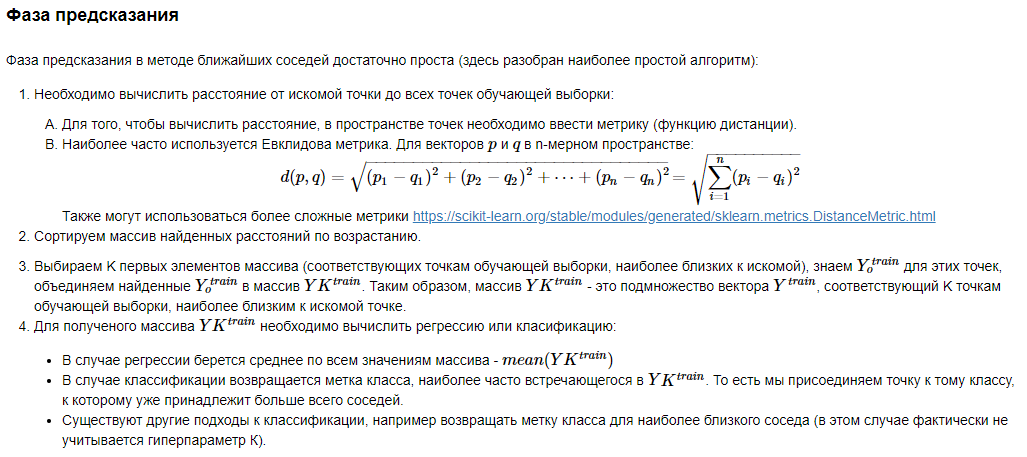

In [25]:
# первая строка тестовой выборки
data_test_0 = [x for x in x_test[['Solids','Chloramines', 'Sulfate', 'Organic_carbon']].iloc[0]]
data_test_0

[14775.14559575291, 7.484103646670236, 305.82855327870027, 12.309015955365226]

In [26]:
# построим предсказание для одного объекта (классификация)
simple_knn_class_0 = simple_knn_class.predict_for_single_object(K=5, \
                          prediction_type=PredictionType.CLASSIFICATION, \
                          X_o=data_test_0, verbose=False)
simple_knn_class_0

'Not_safe'

### **Метод К ближайших соседей: использование класса scikit-learn**

In [27]:
model = KNeighborsClassifier(n_neighbors=3)
model

KNeighborsClassifier(n_neighbors=3)

In [28]:
model.fit(x_train[['Solids','Chloramines', 'Sulfate', 'Organic_carbon']], y_train)
m_predict = model.predict(x_test[['Solids','Chloramines', 'Sulfate', 'Organic_carbon']])
m_predict_train = model.predict(x_train[['Solids','Chloramines', 'Sulfate', 'Organic_carbon']])

Для сравнения построим модель с 10 ближайшими соседями

In [29]:
model2 = KNeighborsClassifier(n_neighbors=10)
model2.fit(x_train[['Solids','Chloramines', 'Sulfate', 'Organic_carbon']], y_train)
m2_predict = model2.predict(x_test[['Solids','Chloramines', 'Sulfate', 'Organic_carbon']])

## **Оценка качества модели**

**Метрики качества классификации**
- Accuracy
- Матрица ошибок или Confusion Matrix
- Precision, recall и F-мера
- ROC-кривая и ROC AUC
- Кривая precision-recall
- Логистическая функция потерь - log loss

**Метрики качества регрессии**
- Mean absolute error - средняя абсолютная ошибка
- Mean squared error - средняя квадратичная ошибка, и Root mean squared error - корень из средней квадратичной ошибки
- Median absolute error
- Метрика R2 или коэффициент детерминации

Мы решаем задачу классификации, поэтому проверим соответствующие метрики

### **Accuracy**
Метрика вычисляет процент (долю в диапазоне от 0 до 1) правильно определенных классов.

Accuracy - доля верно предсказанных классификатором положительных и отрицательных объектов:

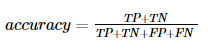

In [30]:
# 1 параметр - эталонное значение классов из исходной (тестовой) выборки
# 2 параметр - предсказанное значение классов

# 3 ближайших соседа
accuracy_score(y_test, m_predict)

0.5274390243902439

In [31]:
# 10 ближайших соседей
accuracy_score(y_test, m2_predict)

0.5685975609756098

Так как у нас бинарная классификация, можем использовать balanced_accuracy_score

In [32]:
# 3 ближайших соседа
balanced_accuracy_score(y_test, m_predict)

0.5000426301878571

In [33]:
# 10 ближайших соседей
balanced_accuracy_score(y_test, m2_predict)

0.5170520751428112

Итог: для 10 соседей точность больше для выборки в целом

Вывод оценок для каждого класса (насколько мы будем предостережены от небезопасной воды, и сколько безопасной воды зря уйдет в утилизацию)

In [34]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

In [35]:
# 3 ближайших соседа
print_accuracy_score_for_classes(y_test, m_predict)

Метка 	 Accuracy
0 	 0.6997319034852547
1 	 0.3003533568904594


In [36]:
# 10 ближайших соседей
print_accuracy_score_for_classes(y_test, m2_predict)

Метка 	 Accuracy
0 	 0.8927613941018767
1 	 0.1413427561837456


### **Матрица ошибок (Confusion Matrix)**
Количество верно и ошибочно классифицированных данных, представленное в виде матрицы

Будем использовать confusion_matrix из sklearn, которая выводит следующую таблицу

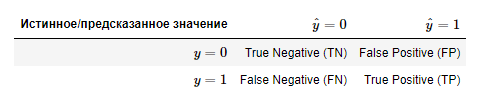

- True Positive (TP) - количество верно предсказанных значений 1 класса
- False Positive (FP) - количество неверно предсказанных значений 1 класса (предсказана 1 но истинное значение 0) - ошибка I рода, «ложное срабатывание».
- True Negative (TN) - количество верно предсказанных значений 0 класса
- False Negative (FN) - количество неверно предсказанных значений 0 класса (предсказан 0 но истинное значение 1) - ошибка II рода, «пропуск цели, пропуск события».

In [37]:
tn, fp, fn, tp = confusion_matrix(y_test, m_predict).ravel()
tn, fp, fn, tp

(261, 112, 198, 85)

Постороим графики plot для наглядности

NameError: name 'plot_confusion_matrix' is not defined

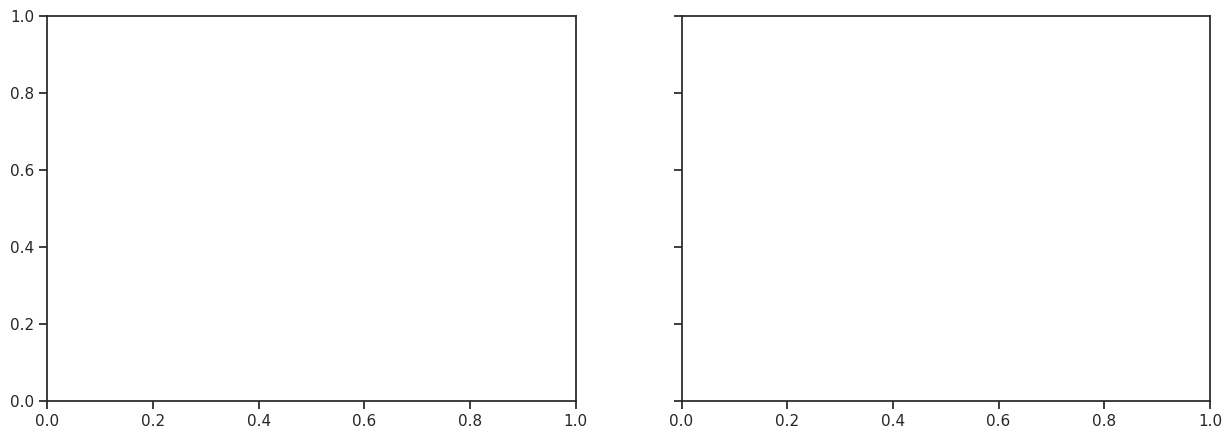

In [38]:
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15,5))
labels = ['Not_safe', 'Is_safe']

plot_confusion_matrix(model, x_test[['Solids','Chloramines', 'Sulfate', 'Organic_carbon']], y_test,
                      display_labels=labels, cmap=plt.cm.Blues, normalize='true', ax=ax[0])

plot_confusion_matrix(model2, x_test[['Solids','Chloramines', 'Sulfate', 'Organic_carbon']], y_test,
                      display_labels=labels, cmap=plt.cm.Blues, normalize='true', ax=ax[1])

fig.suptitle('Матрицы ошибок')
ax[0].title.set_text('K=2')
ax[1].title.set_text('K=10')

Модель 10 соседей лучше предсказывает значения для небезопасной воды, модель 2 соседей для безопасной. В данном случае модель для 10 соседей использовать лучше. 

### **Precision, recall и F-мера**

**Precision** \
Доля верно предсказанных классификатором положительных объектов, из всех объектов, которые классификатор верно или неверно определил как положительные.

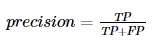

In [ ]:
# По умолчанию метрики считаются для 1 класса бинарной классификации
# Для 3 и 10 ближайших соседей
precision_score(y_test, m_predict), precision_score(y_test, m2_predict)

(0.43147208121827413, 0.5)

У функции precision_score есть параметр average, который указывает как считать TP, TN, FP, FN

In [ ]:
# Параметры TP, TN, FP, FN считаются как сумма по всем классам
precision_score(y_test, m_predict, average='micro'), precision_score(y_test, m2_predict, average='micro')

(0.5274390243902439, 0.5685975609756098)

In [ ]:
# Параметры TP, TN, FP, FN считаются отдельно для каждого класса 
# и берется среднее значение, дисбаланс классов не учитывается.
precision_score(y_test, m_predict, average='macro'), precision_score(y_test, m2_predict, average='macro')

(0.5000497660993332, 0.5390625)

In [ ]:
# Параметры TP, TN, FP, FN считаются отдельно для каждого класса 
# и берется средневзвешенное значение, дисбаланс классов учитывается 
# в виде веса классов (вес - количество истинных значений каждого класса).
precision_score(y_test, m_predict, average='weighted'), precision_score(y_test, m2_predict, average='weighted')

(0.5094582899397223, 0.5444216844512195)

**Recall (полнота)** \
показывает, какую долю объектов, реально относящихся к положительному классу, мы предсказали верно

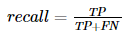

In [ ]:
# Для 3 и 10 ближайших соседей
recall_score(y_test, m_predict), recall_score(y_test, m2_predict)

(0.3003533568904594, 0.1413427561837456)

**F-мера** \
Для того, чтобы объединить precision и recall в единую метрику используется Fβ-мера, которая вычисляется как среднее гармоническое от precision и recall

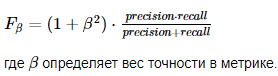

Используются функции f1_score (β=1) и fbeta_score (также есть параметр average)

In [ ]:
# Для 3 и 10 ближайших соседей
fbeta_score(y_test, m_predict, average='macro', beta=0.5), fbeta_score(y_test, m2_predict, average='macro', beta=0.5)

(0.4937952244425762, 0.4768199223035613)

**Удобный вывод метрик** \
Функция classification_report позволяет выводить значения точности, полноты и F-меры для всех классов выборки.

In [ ]:
# Для 3 и 10 ближайших соседей
classification_report(y_test, m_predict, target_names=['Not_safe', 'Is_safe'], output_dict=True), \
 classification_report(y_test, m2_predict, target_names=['Not_safe', 'Is_safe'], output_dict=True)

({'Is_safe': {'f1-score': 0.3541666666666667,
   'precision': 0.43147208121827413,
   'recall': 0.3003533568904594,
   'support': 283},
  'Not_safe': {'f1-score': 0.6274038461538461,
   'precision': 0.5686274509803921,
   'recall': 0.6997319034852547,
   'support': 373},
  'accuracy': 0.5274390243902439,
  'macro avg': {'f1-score': 0.4907852564102564,
   'precision': 0.5000497660993332,
   'recall': 0.5000426301878571,
   'support': 656},
  'weighted avg': {'f1-score': 0.5095286604909318,
   'precision': 0.5094582899397223,
   'recall': 0.5274390243902439,
   'support': 656}},
 {'Is_safe': {'f1-score': 0.22038567493112948,
   'precision': 0.5,
   'recall': 0.1413427561837456,
   'support': 283},
  'Not_safe': {'f1-score': 0.701791359325606,
   'precision': 0.578125,
   'recall': 0.8927613941018767,
   'support': 373},
  'accuracy': 0.5685975609756098,
  'macro avg': {'f1-score': 0.46108851712836774,
   'precision': 0.5390625,
   'recall': 0.5170520751428112,
   'support': 656},
  'weig

### **ROC-кривая(кривая ошибок) и ROC AUC**
ROC-кривая - график, позволяющий оценить качество бинарной классификации, отображает соотношение между долей объектов от общего количества носителей признака, верно классифицированных как несущие признак (TPR), и долей объектов от общего количества объектов, не несущих признака, ошибочно классифицированных как несущие признак (FPR) при варьировании порога решающего правила.

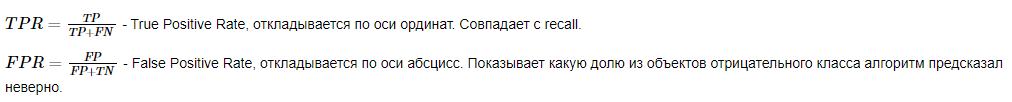

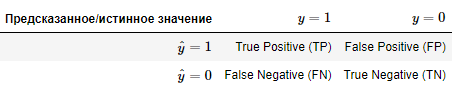

В качестве количественной метрики используется площадь под кривой - ROC AUC (Area Under the Receiver Operating Characteristic Curve). Чем ниже проходит кривая тем меньше ее площадь и тем хуже качество классификатора

In [ ]:
# Отрисовка ROC-кривой
def draw_roc_curve(y_true, y_score, pos_label, average):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, 
                                     pos_label=pos_label)
    roc_auc_value = roc_auc_score(y_true, y_score, average=average)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_value)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

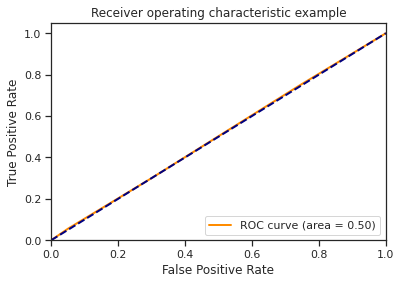

In [ ]:
# для 3 соседей
m_proba = model.predict_proba(x_test[['Solids','Chloramines', 'Sulfate', 'Organic_carbon']])
true_m_proba = m_proba[:,1]
roc_curve_k10_res = roc_curve(y_test, true_m_proba, pos_label=1)
draw_roc_curve(y_test, true_m_proba, pos_label=1, average='micro')

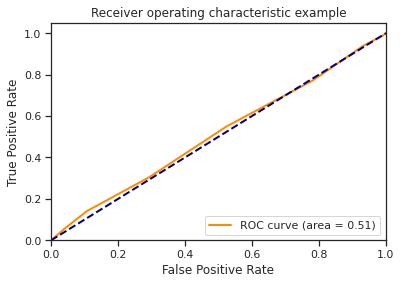

In [ ]:
# для 10 соседей
m2_proba = model2.predict_proba(x_test[['Solids','Chloramines', 'Sulfate', 'Organic_carbon']])
true_m2_proba = m2_proba[:,1]
roc_curve_k10_res = roc_curve(y_test, true_m2_proba, pos_label=1)
draw_roc_curve(y_test, true_m2_proba, pos_label=1, average='micro')

### **Кривая precision-recall**
Аналогично ROC-кривой также можно строить кривую precision-recall. Обычно ее используют в случае сильного дисбаланса классов. У нас классов всего 2, поэтому использовать ее не будем

### **Логистическая функция потерь - log loss**
Обычно используется в том случае, когда предсказывается не значение класса, а его вероятность. Использовать тоже не будем, т.к. у нас бинарная классификация

## **Подбор гиперпараметра K с использованием GridSearchCV и/или RandomizedSearchCV и кросс-валидации**

Чтобы подобрать оптимальную модель, нужно разделить выборку на тестовую и обучающую разными способами, выбрав оптимальный (кросс-валидация) и подобрать оптимальные гиперпараметры. До этого мы просто делили выборку и обучали часть набора, теперь будет действовать по следующему алгоритму:

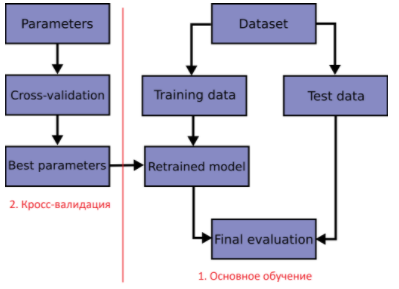

In [ ]:
# удалим target из выборки
data_clean2 = data_clean.drop(columns = ['Potability'], axis = 1)
# переведем в numpy array
data_clean2_np = data_clean2.to_numpy()
target2 = target.to_numpy()

## **Кросс-валидация (скользящий контроль, перекрестная проверка), cross-validation)**

Данные разбиваются на k частей (fold-ов). Кол-во fold-oв - сv. \
Затем на k−1 частях данных производится обучение модели, а оставшаяся часть данных используется для тестирования. Процедура повторяется k раз; в итоге каждая из k частей данных используется для тестирования. В результате получается оценка эффективности выбранной модели с наиболее равномерным использованием имеющихся данных.

Все стратегии кросс-валидации основаны на том, что разработчик задает или количество разбиений (в этом случае автоматически определяются размеры обучающей и тестовой выборок для каждого разбиения) или размер обучающей или тестовой выборки для одного разбиения (в этом случае автоматически определяется количество разбиений).

### **Стратегии кросс валидации (CV): K-fold**
Этот метод случайным образом разбивает данные на k непересекающихся блоков примерно одинакового размера. Поочередно каждый блок рассматривается, как валидационная выборка, а остальные k-1 блоков – как обучающая выборка.

In [ ]:
# разбивает на 3 блока всевозможными способами и вовращает 2 выборки
# тестовая - 1 блок, обучающая - остальные блоки
cv_kf = KFold(n_splits=3)
for train_index, test_index in cv_kf.split(data_clean2):
     print("TRAIN:", train_index, "TEST:", test_index)
     x2_train, x2_test = data_clean2_np[train_index], data_clean2_np[test_index]
     y2_train, y2_test = target2[train_index], target2[test_index]
     print("x2_train: ", x2_train.shape, "\nx2_test: ", x2_test.shape, "y2_train: ", y2_train.shape, "\ny2_test: ", y2_test.shape)

TRAIN: [1092 1093 1094 ... 3273 3274 3275] TEST: [   0    1    2 ... 1089 1090 1091]
x2_train:  (2184, 4) 
x2_test:  (1092, 4) y2_train:  (2184,) 
y2_test:  (1092,)
TRAIN: [   0    1    2 ... 3273 3274 3275] TEST: [1092 1093 1094 ... 2181 2182 2183]
x2_train:  (2184, 4) 
x2_test:  (1092, 4) y2_train:  (2184,) 
y2_test:  (1092,)
TRAIN: [   0    1    2 ... 2181 2182 2183] TEST: [2184 2185 2186 ... 3273 3274 3275]
x2_train:  (2184, 4) 
x2_test:  (1092, 4) y2_train:  (2184,) 
y2_test:  (1092,)


### **CV: Repeated K-Fold**
Повторяет стратегию K-Fold заданное количество раз.

In [ ]:
kf = RepeatedKFold(n_splits=3, n_repeats=2)
for train_index, test_index in kf.split(data_clean2):
     print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [   2    3    6 ... 3270 3274 3275] TEST: [   0    1    4 ... 3271 3272 3273]
TRAIN: [   0    1    3 ... 3272 3273 3275] TEST: [   2    6   10 ... 3269 3270 3274]
TRAIN: [   0    1    2 ... 3272 3273 3274] TEST: [   3    7    9 ... 3267 3268 3275]
TRAIN: [   2    5    7 ... 3270 3272 3274] TEST: [   0    1    3 ... 3271 3273 3275]
TRAIN: [   0    1    3 ... 3272 3273 3275] TEST: [   2    5    9 ... 3269 3270 3274]
TRAIN: [   0    1    2 ... 3273 3274 3275] TEST: [   7   10   15 ... 3260 3267 3272]


### **CV: Leave One Out (LOO)**
В тестовую выборку помещается единственный элемент (One Out). Количество фолдов в этом случае определяется автоматически и равняется количеству элементов. \
LeaveOneOut() - *Эквивалент KFold(n_splits=n)* \
Кол-во разбиений в таком случае будет слишком большое

In [ ]:
kf = LeaveOneOut()
# for train_index, test_index in kf.split(data_clean2):
#      print("TRAIN:", train_index, "TEST:", test_index)

### **CV: Leave P Out (LPO)**
В тестовую выборку помещается P элементов (P Out), полностью перебираются все уникальные комбинации из P элементов. Количество фолдов в этом случае определяется автоматически. \
LeavePOut(number_of_elements)

In [ ]:
kf = LeavePOut(100)
# for train_index, test_index in kf.split(data_clean2):
#      print("TRAIN:", train_index, "TEST:", test_index)

### **CV: ShuffleSplit**
Генерируется N случайных перемешиваний данных, в каждом перемешивании заданная доля помещается в тестовую выборку.

In [ ]:
kf = ShuffleSplit(n_splits=5, test_size=0.25)
# for train_index, test_index in kf.split(data_clean2):
#      print("TRAIN:", train_index, "TEST:", test_index)

### **CV: StratifiedKFold, StratifiedShuffleSplit**
Модели со стратификацией используются для дисбалансированных выборок

Определим, сблансирована ли наша выборка

In [ ]:
def class_proportions(array: np.ndarray) -> Dict[int, Tuple[int, float]]:
    """
    Вычисляет пропорции классов
    array - массив, содержащий метки классов
    """
    # Получение меток классов и количества меток каждого класса 
    labels, counts = np.unique(array, return_counts=True)
    # Превращаем количество меток в процент их встречаемости
    # делим количество меток каждого класса на общее количество меток
    counts_perc = counts/array.size
    # Теперь sum(counts_perc)==1.0
    # Создаем результирующий словарь,
    # ключом словаря явлется метка класса, 
    # а значением словаря процент встречаемости метки
    res = dict()
    for label, count2 in zip(labels, zip(counts, counts_perc)):
        res[label] = count2
    return res

def print_class_proportions(array: np.ndarray):
    """
    Вывод пропорций классов
    """
    proportions = class_proportions(array)
    if len(proportions)>0:
        print('Метка \t Количество \t Процент встречаемости')
    for i in proportions:
        val, val_perc = proportions[i]
        val_perc_100 = round(val_perc * 100, 2)
        print('{} \t {} \t \t {}%'.format(i, val, val_perc_100))

In [ ]:
print_class_proportions(target)

Метка 	 Количество 	 Процент встречаемости
0 	 1998 	 	 60.99%
1 	 1278 	 	 39.01%


Выборка не сбланасирована, значит воспользуемся этими методами. В полученных блоках будет равно кол-во значений по классам Is_safe и Not_safe

In [ ]:
kf = StratifiedKFold(n_splits=3)
for train_index, test_index in kf.split(data_clean2, target):
     print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [ 986  987  988 ... 3273 3274 3275] TEST: [   0    1    2 ... 1173 1174 1175]
TRAIN: [   0    1    2 ... 3273 3274 3275] TEST: [ 986  987  988 ... 2349 2350 2351]
TRAIN: [   0    1    2 ... 2349 2350 2351] TEST: [2132 2133 2134 ... 3273 3274 3275]


### **Автоматическое определение стратегии кросс-валидации**

С помощью функций cross_val_score и cross_validate стратегия кросс-валидации определяется автоматически

In [ ]:
scores = cross_val_score(KNeighborsClassifier(n_neighbors=2), 
                         data_clean2, target, cv=3,
                        scoring='f1_weighted')
scores, np.mean(scores)

(array([0.53300914, 0.53450832, 0.52546197]), 0.530993145112893)

In [ ]:
scoring = {'precision': 'precision_weighted', 
           'recall': 'recall_weighted',
           'f1': 'f1_weighted'}

scores = cross_validate(KNeighborsClassifier(n_neighbors=2), 
                        data_clean2, target, scoring=scoring, 
                        cv=3, return_train_score=True)
scores

{'fit_time': array([0.00775719, 0.00384736, 0.00403404]),
 'score_time': array([0.03542876, 0.05555677, 0.06225705]),
 'test_f1': array([0.53300914, 0.53450832, 0.52546197]),
 'test_precision': array([0.54103369, 0.55821346, 0.53512798]),
 'test_recall': array([0.58424908, 0.59981685, 0.58333333]),
 'train_f1': array([0.7359999 , 0.71687924, 0.73974906]),
 'train_precision': array([0.83137748, 0.8243021 , 0.83282031]),
 'train_recall': array([0.76694139, 0.75320513, 0.76968864])}

## **Оптимизация гиперпараметров**

### **Grid Search (решетчатый поиск)**

In [ ]:
# массив гиперпараметров для проверки
n_range = np.array(range(5,105,5))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters, len(n_range)

([{'n_neighbors': array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
           70,  75,  80,  85,  90,  95, 100])}], 20)

In [ ]:
%%time
m_gs = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='accuracy')
m_gs.fit(x_train[['Solids','Chloramines', 'Sulfate', 'Organic_carbon']], y_train)

CPU times: user 2.59 s, sys: 29.2 ms, total: 2.62 s
Wall time: 2.61 s


### **Randomized Search (случайный поиск)**

In [ ]:
%%time
m_rs = RandomizedSearchCV(KNeighborsClassifier(), tuned_parameters, cv=5, scoring='accuracy')
m_rs.fit(x_train[['Solids','Chloramines', 'Sulfate', 'Organic_carbon']], y_train)

CPU times: user 1.26 s, sys: 18.2 ms, total: 1.28 s
Wall time: 1.28 s


### **Оценка качества оптимальной модели для grid и randomized search**

In [ ]:
df_gs = pd.DataFrame(m_gs.cv_results_)
df_rs = pd.DataFrame(m_rs.cv_results_)
print(df_gs.shape, df_rs.shape)

(20, 14) (10, 14)


In [ ]:
df_gs

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005445,0.001545,0.021289,0.004555,5,{'n_neighbors': 5},0.543893,0.568702,0.540076,0.578244,0.566794,0.559542,0.014900,20
1,0.004736,0.001646,0.021617,0.004505,10,{'n_neighbors': 10},0.601145,0.595420,0.595420,0.604962,0.574427,0.594275,0.010564,18
2,0.004199,0.000345,0.018007,0.001705,15,{'n_neighbors': 15},0.601145,0.583969,0.574427,0.604962,0.574427,0.587786,0.013000,19
3,0.003946,0.000240,0.018822,0.001172,20,{'n_neighbors': 20},0.610687,0.597328,0.589695,0.620229,0.589695,0.601527,0.012094,16
4,0.003746,0.000046,0.017442,0.000597,25,{'n_neighbors': 25},0.601145,0.595420,0.593511,0.608779,0.587786,0.597328,0.007141,17
5,0.003949,0.000314,0.018886,0.001242,30,{'n_neighbors': 30},0.603053,0.614504,0.601145,0.624046,0.603053,0.609160,0.008820,13
6,0.004249,0.000684,0.019424,0.000605,35,{'n_neighbors': 35},0.601145,0.606870,0.597328,0.620229,0.603053,0.605725,0.007878,15
7,0.004274,0.000802,0.021738,0.003792,40,{'n_neighbors': 40},0.610687,0.612595,0.603053,0.620229,0.599237,0.609160,0.007381,13
8,0.003917,0.000198,0.021450,0.003699,45,{'n_neighbors': 45},0.620229,0.608779,0.597328,0.625954,0.595420,0.609542,0.012106,12
9,0.003785,0.000039,0.019701,0.000376,50,{'n_neighbors': 50},0.618321,0.610687,0.612595,0.624046,0.610687,0.615267,0.005205,11


In [ ]:
df_rs

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.004099,0.000720,0.017204,0.000299,20,{'n_neighbors': 20},0.610687,0.597328,0.589695,0.620229,0.589695,0.601527,0.012094,7
1,0.005262,0.002282,0.025997,0.003294,95,{'n_neighbors': 95},0.620229,0.620229,0.618321,0.624046,0.618321,0.620229,0.002091,2
2,0.003915,0.000214,0.017797,0.000549,25,{'n_neighbors': 25},0.601145,0.595420,0.593511,0.608779,0.587786,0.597328,0.007141,8
3,0.003793,0.000073,0.019444,0.001387,35,{'n_neighbors': 35},0.601145,0.606870,0.597328,0.620229,0.603053,0.605725,0.007878,6
4,0.004342,0.000874,0.021217,0.003672,45,{'n_neighbors': 45},0.620229,0.608779,0.597328,0.625954,0.595420,0.609542,0.012106,5
5,0.003798,0.000048,0.021918,0.001221,75,{'n_neighbors': 75},0.612595,0.620229,0.618321,0.629771,0.614504,0.619084,0.005986,4
6,0.003833,0.000074,0.018756,0.003002,10,{'n_neighbors': 10},0.601145,0.595420,0.595420,0.604962,0.574427,0.594275,0.010564,9
7,0.004220,0.000593,0.016570,0.000730,5,{'n_neighbors': 5},0.543893,0.568702,0.540076,0.578244,0.566794,0.559542,0.014900,10
8,0.004409,0.001259,0.023495,0.001221,90,{'n_neighbors': 90},0.622137,0.620229,0.618321,0.622137,0.618321,0.620229,0.001707,1
9,0.003848,0.000141,0.021661,0.000987,70,{'n_neighbors': 70},0.616412,0.618321,0.620229,0.625954,0.616412,0.619466,0.003540,3


In [ ]:
n_range_rs = np.array(list(map(lambda x: x['n_neighbors'], df_rs.params)))
gs_score = list(zip(n_range_rs, m_rs.cv_results_['mean_test_score']))
gs_score_sorted = sorted(gs_score, key=lambda val: val[0])
gs_sorted_neighbors = [x[0] for x in gs_score_sorted]
gs_mean_test_score = [x[1] for x in gs_score_sorted]

In [ ]:
# Лучшая модель
m_gs.best_estimator_, m_rs.best_estimator_

(KNeighborsClassifier(n_neighbors=85), KNeighborsClassifier(n_neighbors=90))

In [ ]:
# Лучшее значение метрики
m_gs.best_score_, m_rs.best_score_

(0.6229007633587786, 0.6202290076335879)

In [ ]:
# Лучшее значение параметров
m_gs.best_params_, m_rs.best_params_

({'n_neighbors': 85}, {'n_neighbors': 90})

In [ ]:
m_gs.best_index_

16

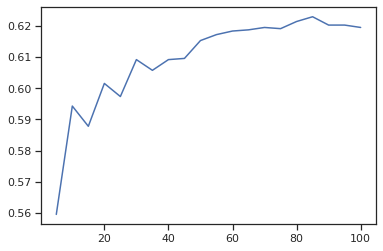

In [ ]:
# Изменение качества на тестовой выборке в зависимости от К-соседей
plt.plot(n_range, m_gs.cv_results_['mean_test_score'])

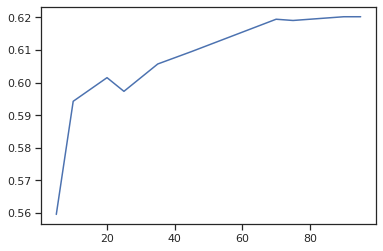

In [ ]:
plt.plot(gs_sorted_neighbors, gs_mean_test_score)

### **Построение кривых обучения и валидации**
Кривая обучения - зависимость метрики на обучающей выборке от размера выборки. \
Кривая валидации -  зависимость метрики на тестовой выборке от одного из гиперпараметров.

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.3,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

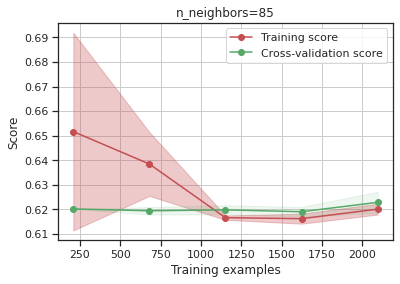

In [ ]:
plot_learning_curve(KNeighborsClassifier(n_neighbors=85), 'n_neighbors=85', 
                    x_train[['Solids','Chloramines', 'Sulfate', 'Organic_carbon']], y_train, cv=5)

In [ ]:
def plot_validation_curve(estimator, title, X, y, 
                          param_name, param_range, cv, 
                          scoring="accuracy"):
                                                   
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name, param_range=param_range,
        cv=cv, scoring=scoring, n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title(title)
    plt.xlabel(param_name)
    plt.ylabel(str(scoring))
    plt.ylim(0.0, 1.1)
    lw = 2
    plt.plot(param_range, train_scores_mean, label="Training score",
                 color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.4,
                     color="darkorange", lw=lw)
    plt.plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy", lw=lw)
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

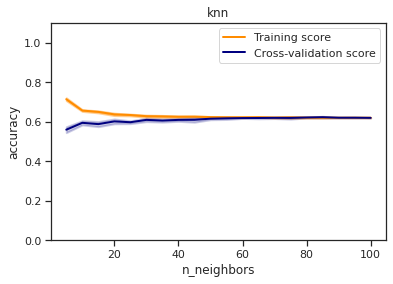

In [ ]:
plot_validation_curve(KNeighborsClassifier(), 'knn', 
                      x_train[['Solids','Chloramines', 'Sulfate', 'Organic_carbon']], y_train, 
                      param_name='n_neighbors', param_range=n_range, 
                      cv=5, scoring="accuracy")

## **Поиск оптимальной модели и сравнение с исходной**

In [ ]:
n_splits_arr = [2, 3, 5, 10, 20]

In [ ]:
scores_all = []
for n_splits in n_splits_arr:
  cv_strategies = [('KFold', KFold(n_splits=n_splits)), ('ShuffleSplit', ShuffleSplit(n_splits=n_splits, test_size=0.25)), \
                    ('StratifiedKFold', StratifiedKFold(n_splits=n_splits)), ('StratifiedShuffleSplit', StratifiedShuffleSplit(n_splits=n_splits))]

  for cv_strategy in cv_strategies:
    gs_model = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=cv_strategy[1], scoring='accuracy')
    gs_model.fit(data_clean2, target)
    scores_all.append({
        'score': gs_model.best_score_,
        'model' : gs_model.best_estimator_,
        'n_splits' : n_splits,
        'cv_strategy' : cv_strategy[0],
        })

In [ ]:
scores_sorted = sorted(scores_all, key=lambda val: val['score'])

In [ ]:
scores_sorted

In [ ]:
scores_sorted[-1]

{'cv_strategy': 'StratifiedShuffleSplit',
 'model': KNeighborsClassifier(n_neighbors=30),
 'n_splits': 2,
 'score': 0.6173780487804879}

In [ ]:
scores_opt = []
cv_opt = StratifiedShuffleSplit(n_splits=2, test_size=0.25)
for train_index, test_index in cv_opt.split(data_clean2, target):
    #  print("TRAIN:", train_index, "TEST:", test_index)
     x2_train, x2_test = data_clean2_np[train_index], data_clean2_np[test_index]
     y2_train, y2_test = target2[train_index], target2[test_index]
     model_opt = KNeighborsClassifier(n_neighbors=30)
     model_opt.fit(x2_train, y2_train)
     m_opt_predict_test = model_opt.predict(x2_test)
     m_opt_predict_train = model_opt.predict(x2_train)
    #  classification_report(y2_test, m_opt_predict, target_names=['Not_safe', 'Is_safe'], output_dict=True)
     scores_opt.append((accuracy_score(y2_train, m_opt_predict_train), accuracy_score(y2_test, m_opt_predict_test)))

In [ ]:
scores_opt = []
type(scores_opt)

In [ ]:
p = [15, 19]
p.append(0)
print(p)

In [ ]:
# точность оптимальной модели
scores_opt

[(0.6198616198616199, 0.6068376068376068),
 (0.6214896214896215, 0.5934065934065934)]

In [ ]:
# точность исходной модели
(accuracy_score(y_train, m_predict_train), accuracy_score(y_test, m_predict))

(0.7698473282442748, 0.5274390243902439)

In [ ]:
x_test.head()

,Solids,Chloramines,Sulfate,Organic_carbon,Potability
136,14775.145596,7.484104,305.828553,12.309016,0
600,27071.118618,6.220936,298.112645,16.768945,0
1784,50279.262429,5.905056,415.450810,11.949854,0
3061,40175.206091,7.487423,309.800796,11.186739,0
2779,21379.963927,5.407692,227.665635,15.772334,1


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

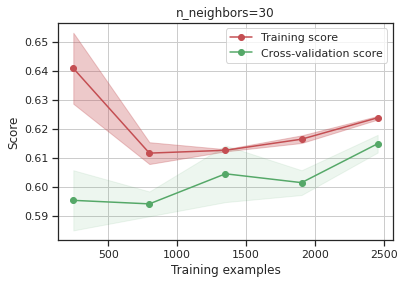

In [ ]:
plot_learning_curve(KNeighborsClassifier(n_neighbors=30), 'n_neighbors=30', 
                    data_clean2, target, cv=StratifiedShuffleSplit(n_splits=2, test_size=0.25))

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

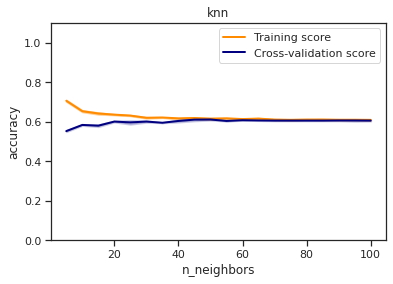

In [ ]:
plot_validation_curve(KNeighborsClassifier(n_neighbors=30), 'knn', 
                      data_clean2, target, 
                      param_name='n_neighbors', param_range=n_range, 
                      cv=StratifiedShuffleSplit(n_splits=2, test_size=0.25), scoring="accuracy")

### **Исходная модель**

In [ ]:
x_test.shape, x_train.shape, data_clean.shape

((656, 5), (2620, 6), (3276, 5))

In [ ]:
kf4 = LeavePOut(656)
model4 = KNeighborsClassifier(n_neighbors=3)
for train_index, test_index in kf4.split(data_clean2):
  # print("TRAIN:", train_index, "TEST:", test_index)
  x4_train, x4_test = data_clean2_np[train_index], data_clean2_np[test_index]
  y4_train, y4_test = target2[train_index], target2[test_index]
  model4.fit(x4_train, y4_train)
  m4_predict_test = model4.predict(x4_test)
  m4_predict_train = model4.predict(x4_train)
  print((accuracy_score(y4_train, m4_predict_train), accuracy_score(y4_test, m4_predict_test)))
  break

(0.7645038167938931, 0.5838414634146342)


In [ ]:
model3 = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=LeaveOneOut(), scoring='accuracy')
model3.fit(data_clean2, target)

### **Проверка качества с помощью LeaveOneOut**

In [ ]:
# Оценка качества модели с использованием кросс-валидации
scores2 = cross_val_score(KNeighborsClassifier(n_neighbors=50), 
                         data_clean2, target, 
                         cv=LeaveOneOut())

In [ ]:
scores2, np.mean(scores2)

(array([1., 1., 1., ..., 0., 0., 0.]), 0.5952380952380952)

In [ ]:
model3 = GridSearchCV(KNeighborsClassifier(), tuned_parameters, cv=LeaveOneOut(), scoring='accuracy')
model3.fit(data_clean2, target)

GridSearchCV(cv=LeaveOneOut(), estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100])}],
             scoring='accuracy')

In [ ]:
model3.best_estimator_

KNeighborsClassifier(n_neighbors=35)

In [ ]:
model3.best_params_, model3.best_score_

({'n_neighbors': 35}, 0.6062271062271062)

In [ ]:
# Обучение модели и оценка качества с учетом подобранных гиперпараметров
model3.best_estimator_.fit(x_train[['Solids','Chloramines', 'Sulfate', 'Organic_carbon']], y_train)
target2_0 = model3.best_estimator_.predict(x_train[['Solids','Chloramines', 'Sulfate', 'Organic_carbon']])
target2_1 = model3.best_estimator_.predict(x_test[['Solids','Chloramines', 'Sulfate', 'Organic_carbon']])

In [ ]:
# Новое качество модели
accuracy_score(y_train, target2_0), accuracy_score(y_test, target2_1)

(0.6229007633587786, 0.5655487804878049)

### **Проверка для малого количества соседей**

In [ ]:
# массив гиперпараметров для проверки
n_range2 = np.array(range(1,10,1))
tuned_parameters2 = [{'n_neighbors': n_range2}]
tuned_parameters2, len(n_range2)

([{'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9])}], 9)

In [ ]:
n_splits_arr2 = [2, 3, 5, 10]
scores_all2 = []
for n_splits in n_splits_arr2:
  cv_strategies = [('KFold', KFold(n_splits=n_splits)), ('ShuffleSplit', ShuffleSplit(n_splits=n_splits, test_size=0.25)), \
                    ('StratifiedKFold', StratifiedKFold(n_splits=n_splits)), ('StratifiedShuffleSplit', StratifiedShuffleSplit(n_splits=n_splits))]

  for cv_strategy in cv_strategies:
    gs_model = GridSearchCV(KNeighborsClassifier(), tuned_parameters2, cv=cv_strategy[1], scoring='accuracy')
    gs_model.fit(data_clean2, target)
    scores_all2.append({
        'score': gs_model.best_score_,
        'model' : gs_model.best_estimator_,
        'n_splits' : n_splits,
        'cv_strategy' : cv_strategy[0],
        })

In [ ]:
scores_sorted2 = sorted(scores_all2, key=lambda val: val['score'])
scores_sorted2[-1]

{'cv_strategy': 'StratifiedShuffleSplit',
 'model': KNeighborsClassifier(n_neighbors=4),
 'n_splits': 3,
 'score': 0.5955284552845529}

### **LeavePOut**

In [ ]:
# Оценка качества модели с использованием кросс-валидации
scores3 = cross_val_score(KNeighborsClassifier(n_neighbors=50), 
                         data_clean2, target, 
                         cv=LeavePOut(656))

In [ ]:
scores3